Код по статье https://pdfs.semanticscholar.org/bb92/da93fb97510c00968255de7f872b8e99fba9.pdf

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

Считаем нулевой слой - самим признаковым пространством объекта.
Т.е. у нас есть один скрытый слой с 5 нейронами и softmax-слой с 3 выходами

Обрати внимание на переменную log_prior_initial_value.
Это логарифм значения диагональных элементов ковариационной матрицы.

В дальнейшем ковариация используется только в логарифмическом виде, т.к. при оптимизации этого параметра 
"в тупую", без логарифма градиент достаточно неустойчивый и может произойти переполнение и выход в NaN.

Evidence полагается на распределение параметров, для каждого шага оптимизации полагается сэмплировать параметры.
При оптимизации гиперпараметров, шум, который возникает при сэмплировании, может сильно замедлить процесс оптимизации (в то же время, совсем выключать его некорректно по определению Evidence).
Поэтому во время оптимизации гиперпараметров предлагается запускать порождать несколько векторов параметров и усреднять их результат. За количество сэмплов отвечает переменная validation_sample_num

Для оптимизации гиперпараметров используется градиентный спуск с шагом hyper_learning_rate. 


In [3]:
batch_size = 20
layers = [13, 5, 3] # layer 0  = X matrix
iter_num = 4000
learning_rate = 0.5
log_prior_initial_value = 0.0
validation_sample_num = 5
hyper_learning_rate= 10**(-2)

In [4]:
train = pd.read_csv( "train.csv")
del train['Unnamed: 0']
count_of_train_data = len(train)


test = pd.read_csv(  "test.csv")
del test['Unnamed: 0']

Ytrain = train['Type'].as_matrix()
Ytrain.reshape([-1])
del train['Type']
Xtrain = train.as_matrix()

Ytest = test['Type'].as_matrix()
Ytest.reshape([-1])
del test['Type']
Xtest = test.as_matrix()
print Xtrain.shape, Xtest.shape

(144, 13) (34, 13)


объявление переменных.
У нас есть две переменные, отвечающие за вариационное распределение Q:
params_mean и log_params_sigma, среднее и отклонение параметров соответственно.

Вектора из params_noises --- просто гауссовый шум

Также я добавил переменную Noise_on, т.к. при подсчете accuracy имеет смысл выключать шум и учитывать только среднее значение параметров.

In [5]:
X = tf.placeholder(tf.float64, [None, Xtrain.shape[1]])
Y = tf.placeholder(tf.int32, [None])
Noise_on = tf.placeholder(tf.float64, [])

param_num = sum([layers[i]*layers[i+1] for i in xrange(0,len(layers)-1)]) + sum(layers[1:]) # Matrices + Biases

params_mean = tf.Variable(np.random.rand(param_num)*0.01, dtype=tf.float64, name="mean")
log_params_sigma = tf.Variable(np.ones(param_num)*0.01, dtype=tf.float64, name="sigma")
params_noises = []
for _ in xrange(validation_sample_num):
    noise = tf.random_normal([param_num], dtype=tf.float64) 
    #
    params_noises.append(noise)
    
log_prior_diagonal =  tf.Variable(np.ones(param_num)*log_prior_initial_value, dtype=tf.float64,name='log_prior')


Послойное построение модели.
Вынесено как функция, возвращающая выход модели и softmax-правдоподобие.


In [6]:
def build(noise_id=0, x_tensor=X,y_tensor=Y, means=params_mean, log_sigmas=log_params_sigma):
    noise = params_noises[noise_id]
    params_noisy = means +  tf.scalar_mul(Noise_on,  tf.multiply(noise, tf.exp(log_sigmas)))
    
    current_layer = x_tensor
    matrix_offset = 0
    bias_offset = sum([layers[i]*layers[i+1] for i in xrange(0,len(layers)-1)])
    for layer_id in xrange(len(layers)-1):

        activation = tf.sigmoid if layer_id < len(layers)-2 else lambda x: x
        matrix_params = tf.reshape(params_noisy[matrix_offset:matrix_offset + layers[layer_id]*layers[layer_id+1]],
                                   (layers[layer_id], layers[layer_id+1]))
        bias_params = params_noisy[bias_offset:bias_offset + layers[layer_id+1]]

        matrix_offset+=layers[layer_id]*layers[layer_id+1]
        bias_offset+=layers[layer_id+1]
        current_layer = activation(tf.matmul(current_layer,matrix_params)+bias_params)
    softmax_loss =  tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=y_tensor, logits=current_layer))*Xtrain.shape[0]
    return current_layer, softmax_loss

network_last_layer, parameters_train_softmax_loss = build()
predict = tf.argmax(network_last_layer, axis=1)


Для подсчета D_KL имеет смысл использовать стандартную формулу, которая дана в википедии.
https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions

Функция потерь состоит из двух слагаемых, первое из которых расчитывается (всегда!) для выборки фиксированного размера. Чтобы использовать мини-батчи нужно взять среднее от софтмакса и домножить на размер выборки.

Таким образом, порядок величины будет всегда постоянным вне зависимости от размера батча, и будет корректно соотноситься с размером D_KL.

norm_loss --- номировка функции, независимая от размера выборки. Удобна для подбора learning rate.

In [7]:
D_KL_part0 = tf.reduce_sum(tf.exp(2*log_params_sigma-2*log_prior_diagonal))
D_KL_part1 = tf.reduce_sum(tf.multiply(params_mean/tf.exp(2*log_prior_diagonal), (params_mean)))
D_KL_part2 = -param_num
D_KL_part3 = 2*tf.reduce_sum(log_prior_diagonal) - 2*tf.reduce_sum(log_params_sigma)
D_KL = 0.5*(D_KL_part0+D_KL_part1+D_KL_part2+D_KL_part3)
loss =parameters_train_softmax_loss+D_KL
norm_loss = loss/Xtrain.shape[0]

In [8]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(norm_loss, var_list=[params_mean, log_params_sigma])

Идея оптимизации гиперпараметров изложена в 
https://arxiv.org/pdf/1511.06727.pdf

Пусть $L$ --- функция потерь, $\mathbf{w}$ --- параметры, $\mathbf{h}$ --- гиперпараметры, $\gamma$ --- длина шага оптимизации,  $\gamma'$ --- длина шага оптимизации гиперпараметров.

1. Считаем градиенты $\nabla_\mathbf{w} L(\mathbf{w})$  (в коде: grads)
2. Получаем предсказание новых параметров (оптимизацию мы еще не провели): $\mathbf{w}' =\mathbf{w} - \gamma  \nabla_\mathbf{w} L(\mathbf{w})$ (в коде: new_means, new_sigmas)
3. Вычисляем значение функции потерь на предсказанных параметрах   L(\mathbf{w}') (в коде: full_hyperparameter_optimization_loss)
4. Вычисляем градиент гиперпараметров по предсказанным параметрам: $\mathbf{h}' =\mathbf{h} - \gamma  \nabla_\mathbf{h} L(\mathbf{w}')$  (в коде: hyperoptimizer)

Как можно видеть, такая оптимизация получается достаточно "жадной", т.к. смотрит на один шаг оптимизации вперед. Тем не менее, она показывает достаточно хорошее качество, и не очень сильно тормозит (в сравнении с другими градиентными методами).

Тут надо заметить, что в общем случае оптимизации параметров и гиперпараметров на одной выборке и одной функции $L$ является некорректной, т.к. ведет к переобучению. Но конкретно Evidence --- показатель сложности из байесовского вывода, которая как раз должна контролировать переобучение и (в теории), оптимизация гиперпараметров таким способом не должна вести к переобучению.

In [9]:
train_optimization_loses =[]
for noise_id in xrange((validation_sample_num)):
    _, softmax_loss = build(noise_id=noise_id)
    train_optimization_loses.append(softmax_loss)

full_train_optimization_loss = (tf.reduce_mean(train_optimization_loses) + D_KL)/Xtrain.shape[0]
grads = tf.gradients(full_train_optimization_loss, [params_mean, log_params_sigma])
new_means =params_mean -  tf.scalar_mul(learning_rate,grads[0])
new_sigmas =log_params_sigma -   tf.scalar_mul(learning_rate,grads[1])

expected_losses_after_training_step = []
for noise_id in xrange((validation_sample_num)):
    _, softmax_loss = build(noise_id=noise_id, log_sigmas=new_sigmas, means=new_means)
    expected_losses_after_training_step.append(softmax_loss/Xtrain.shape[0])
    
full_hyperparameter_optimization_loss = tf.reduce_mean(expected_losses_after_training_step) + D_KL/Xtrain.shape[0]
hyperoptimizer = tf.train.GradientDescentOptimizer(hyper_learning_rate).minimize(full_hyperparameter_optimization_loss, var_list=[log_prior_diagonal])

Оптимизация. 
Идет значительно дольше, чем обычно из-за оптимизации гиперпараметров. 
По идее, можно проводить оптимизацию гиперпараметров не каждый шаг, а каждый K-й шаг.

Значение функции ошибки доходит где-то до 0.3, без оптимизации гиперпараметров до 0.6


In [10]:
indices = np.arange(Xtrain.shape[0])
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
# Train
for iter_id in range(iter_num):
    
    np.random.shuffle(indices)
    batch_xs, batch_ys = Xtrain[indices[:batch_size]], Ytrain[indices[:batch_size]]
    sess.run(optimizer, feed_dict={X: batch_xs, Y: batch_ys, Noise_on:1.0})
    sess.run(hyperoptimizer, feed_dict={X: batch_xs, Y: batch_ys, Noise_on:1.0})
    if iter_id %100 ==0:
        print 'Current Negative Evidence Value', sess.run(full_train_optimization_loss, feed_dict={X: batch_xs, Y: batch_ys, Noise_on:1.0})
        

Current Negative Evidence Value 1.9481839688009879
Current Negative Evidence Value 0.7557273646058338
Current Negative Evidence Value 0.5411230352330353
Current Negative Evidence Value 0.48835753615763333
Current Negative Evidence Value 0.4922345225921691
Current Negative Evidence Value 0.4337001289945601
Current Negative Evidence Value 0.5557949168636
Current Negative Evidence Value 0.4591456285593813
Current Negative Evidence Value 0.6194664437487163
Current Negative Evidence Value 0.44692480876485174
Current Negative Evidence Value 0.45194904770795585
Current Negative Evidence Value 0.46458310893187993
Current Negative Evidence Value 0.4524801203708402
Current Negative Evidence Value 0.4110467912262881
Current Negative Evidence Value 0.42566251937192207
Current Negative Evidence Value 0.4047440569915696
Current Negative Evidence Value 0.4484063962006244
Current Negative Evidence Value 0.4748197014640283
Current Negative Evidence Value 0.3993890475697701
Current Negative Evidence Val

In [11]:
print log_prior_diagonal.eval()

[ 0.4509462   0.01296022  0.08429638 -0.08091552  0.09055842 -0.14402647
 -0.01456625 -0.10137628 -0.10559321 -0.06692522  0.2066911  -0.00784687
 -0.06007069 -0.11388554 -0.03169651 -0.01506439 -0.01697802  0.09204491
 -0.02108706  0.0640696  -0.19930579 -0.02369662 -0.06997823 -0.08355656
 -0.05125187 -0.19653902 -0.02423523 -0.00906923  0.00270837 -0.00625812
 -0.06144586  0.01673632  0.12002873  0.25201568  0.06263161 -0.20595645
 -0.03814632 -0.07983597 -0.06905319 -0.06434454 -0.11983108 -0.00813991
 -0.08101347 -0.0508759  -0.05239741  0.32555478  0.03759225 -0.09361003
  0.04706109 -0.04736552  0.30055063  0.04189746 -0.06410321  0.11112653
 -0.04687927 -0.18841861  0.01526692  0.09517976  0.23541169  0.05291239
  0.50607412 -0.01085597  0.29465138 -0.01775956  0.18549391  0.08066453
  1.44665529  0.23569962 -0.16246324 -0.10662447 -0.04578853  0.57052132
 -0.07764675  0.04079004  0.3718553  -0.151086    0.80460069  0.23295472
 -0.08558622 -0.06288857  0.13552853 -0.02228213 -0

In [12]:
predicted_train = sess.run(predict, feed_dict={X:Xtrain, Noise_on:0.0}) 
predicted_test = sess.run(predict, feed_dict={X:Xtest, Noise_on:0.0}) 
print 'Accuracy:train', np.mean(np.equal(predicted_train, Ytrain))
print 'Accuracy:test', np.mean(np.equal(predicted_test, Ytest))

Accuracy:train 1.0
Accuracy:test 0.9705882352941176


Сортируем по $\lambda$ и удаляем наименьшие

In [13]:
lambdas = np.argsort(np.abs( params_mean.eval()/np.exp(log_params_sigma.eval())))

In [14]:
acc_train = []
acc_test = []
for percent in xrange(0, 101, 5):
    _params = params_mean.eval()
    null_count = len(_params)*percent/100
    _params[lambdas[:null_count]] = 0
    sess.run(params_mean.assign(_params))
    acc_train.append( np.mean(np.equal(Ytrain, sess.run(predict, feed_dict={X:Xtrain, Noise_on:0.0}) )))
    acc_test.append( np.mean(np.equal(Ytest, sess.run(predict, feed_dict={X:Xtest, Noise_on:0.0}) )))

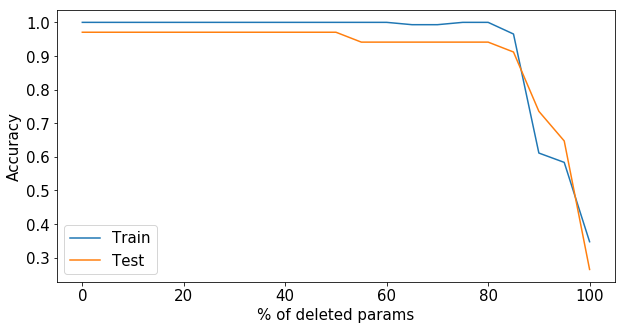

In [15]:
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['font.size'] = 15
plt.plot(range(0, 101, 5), acc_train, label='Train')
plt.plot(range(0, 101, 5),acc_test, label='Test')
plt.legend(loc='best')
plt.xlabel('% of deleted params')
_= plt.ylabel('Accuracy')